# CPU and GPU exploratory Analysis and Predictions

## Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder

In [2]:
# import matplotlib.pyplot as plt
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.impute import SimpleImputer
# from category_encoders import OrdinalEncoder
# from sklearn.metrics import ConfusionMatrixDisplay, classification_report
# from sklearn.model_selection import GridSearchCV, train_test_split
# from sklearn.pipeline import make_pipeline
# import numpy as np
# import warnings
# import datetime
# from sklearn.compose import ColumnTransformer
# warnings.simplefilter(action="ignore", category=np.VisibleDeprecationWarning)
# warnings.simplefilter(action="ignore", category= UserWarning)
# warnings.simplefilter(action="ignore", category= pd.core.common.SettingWithCopyWarning)
# warnings.simplefilter(action="ignore", category=FutureWarning)
# pd.set_option("display.max_columns", 28)

## Loading Data

In [3]:
df = pd.read_csv(r"C:\Users\Lucas\JupyterLab\Projects for Portifolio\CSVs\chip_dataset.csv")

In [4]:
df.drop(columns="Unnamed: 0", inplace=True)

In [5]:
df.duplicated().sum()

110

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.shape

(4744, 13)

In [8]:
df.head()

,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor,FP16 GFLOPS,FP32 GFLOPS,FP64 GFLOPS
0,AMD Athlon 64 3500+,CPU,2007-02-20,65.0,45.0,77.0,122.0,2200.0,Unknown,AMD,NaN,NaN,NaN
1,AMD Athlon 200GE,CPU,2018-09-06,14.0,35.0,192.0,4800.0,3200.0,Unknown,AMD,NaN,NaN,NaN
2,Intel Core i5-1145G7,CPU,2020-09-02,10.0,28.0,NaN,NaN,2600.0,Intel,Intel,NaN,NaN,NaN
3,Intel Xeon E5-2603 v2,CPU,2013-09-01,22.0,80.0,160.0,1400.0,1800.0,Intel,Intel,NaN,NaN,NaN
4,AMD Phenom II X4 980 BE,CPU,2011-05-03,45.0,125.0,258.0,758.0,3700.0,Unknown,AMD,NaN,NaN,NaN


In [9]:
df.duplicated().sum()

0

In [10]:
df.dtypes

Product                   object
Type                      object
Release Date              object
Process Size (nm)        float64
TDP (W)                  float64
Die Size (mm^2)          float64
Transistors (million)    float64
Freq (MHz)               float64
Foundry                   object
Vendor                    object
FP16 GFLOPS              float64
FP32 GFLOPS              float64
FP64 GFLOPS              float64
dtype: object

In [11]:
df["Foundry"].value_counts()

TSMC       2156
Intel      1341
Unknown     838
GF          264
UMC          70
Samsung      59
Sony         10
IBM           3
NEC           2
Renesas       1
Name: Foundry, dtype: int64

# Cleaning Data

Dropping the column "Unnamed: 0" since it has irrelevant information.

The release date is being treated as an object, so it will be converted to datetime, set as index and sorted:

In [12]:
df["Release Date"] = pd.to_datetime(df["Release Date"])

In [13]:
df["year"] = df["Release Date"].dt.year
df["month"] = df["Release Date"].dt.month
df["day"] = df["Release Date"].dt.day

In [14]:
df["Foundry"].value_counts()

TSMC       2156
Intel      1341
Unknown     838
GF          264
UMC          70
Samsung      59
Sony         10
IBM           3
NEC           2
Renesas       1
Name: Foundry, dtype: int64

In [15]:
a = (df["Foundry"].value_counts() < 100)
b = []
for i in range(len(a)):
    if a[i]:
        b.append(a.index[i])

In [16]:
b

['UMC', 'Samsung', 'Sony', 'IBM', 'NEC', 'Renesas']

In [17]:
df["Foundry"] = df["Foundry"].apply(lambda x: "Other" if x in b else x)

In [18]:
df.head()

,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor,FP16 GFLOPS,FP32 GFLOPS,FP64 GFLOPS,year,month,day
0,AMD Athlon 64 3500+,CPU,2007-02-20,65.0,45.0,77.0,122.0,2200.0,Unknown,AMD,NaN,NaN,NaN,2007.0,2.0,20.0
1,AMD Athlon 200GE,CPU,2018-09-06,14.0,35.0,192.0,4800.0,3200.0,Unknown,AMD,NaN,NaN,NaN,2018.0,9.0,6.0
2,Intel Core i5-1145G7,CPU,2020-09-02,10.0,28.0,NaN,NaN,2600.0,Intel,Intel,NaN,NaN,NaN,2020.0,9.0,2.0
3,Intel Xeon E5-2603 v2,CPU,2013-09-01,22.0,80.0,160.0,1400.0,1800.0,Intel,Intel,NaN,NaN,NaN,2013.0,9.0,1.0
4,AMD Phenom II X4 980 BE,CPU,2011-05-03,45.0,125.0,258.0,758.0,3700.0,Unknown,AMD,NaN,NaN,NaN,2011.0,5.0,3.0


Dropping duplicates:

In [19]:
df["Foundry"].value_counts()

TSMC       2156
Intel      1341
Unknown     838
GF          264
Other       145
Name: Foundry, dtype: int64

# Model Building

# Spliting the Data # 1

In [20]:
df.reset_index(inplace=True)

In [21]:
X = df[df["Foundry"] != "Unknown"][['Process Size (nm)', 'TDP (W)', 'Die Size (mm^2)', 'Transistors (million)', 'Freq (MHz)', "day", "month", "year"]]
y = df[df["Foundry"] != "Unknown"]["Foundry"]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# Defining Baseline # 1

In [23]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.5554


## First model: Random Forest Classifier

### Creating the pipeline:

In [24]:
pipe = make_pipeline(SimpleImputer() , RandomForestClassifier(random_state=42))

### Setting parameters:

In [25]:
params = {
    'simpleimputer__strategy' : ['mean', 'median', "most_frequent"],
    "randomforestclassifier__n_estimators": range(90,121,100),
    "randomforestclassifier__max_depth": range(20,46,5),
    "randomforestclassifier__criterion": ["gini", "entropy"]
}

### Building the model:

In [26]:
model_rf = GridSearchCV(
    pipe,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)

### Fitting:

In [27]:
model_rf.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__criterion': ['gini',
                                                               'entropy'],
                         'randomforestclassifier__max_depth': range(20, 46, 5),
                         'randomforestclassifier__n_estimators': range(90, 121, 100),
                         'simpleimputer__strategy': ['mean', 'median',
                                                     'most_frequent']},
             verbose=1)

### Getting results:

In [28]:
cv_results = pd.DataFrame(model_rf.cv_results_)
cv_results.sort_values("rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__criterion,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
27,0.382577,0.054214,0.025133,0.007007,entropy,35,90,mean,{'randomforestclassifier__criterion': 'entropy...,0.9840,0.9840,0.9904,0.9888,0.987179,0.986876,0.002560,1
24,0.355249,0.029582,0.024335,0.002932,entropy,30,90,mean,{'randomforestclassifier__criterion': 'entropy...,0.9840,0.9840,0.9904,0.9888,0.987179,0.986876,0.002560,1
33,0.355449,0.032111,0.024335,0.009326,entropy,45,90,mean,{'randomforestclassifier__criterion': 'entropy...,0.9840,0.9840,0.9904,0.9888,0.987179,0.986876,0.002560,1
21,0.388761,0.084206,0.020345,0.000798,entropy,25,90,mean,{'randomforestclassifier__criterion': 'entropy...,0.9840,0.9840,0.9904,0.9888,0.987179,0.986876,0.002560,1
18,0.360436,0.070593,0.024534,0.006811,entropy,20,90,mean,{'randomforestclassifier__criterion': 'entropy...,0.9840,0.9840,0.9904,0.9888,0.987179,0.986876,0.002560,1
30,0.419877,0.052164,0.034707,0.016525,entropy,40,90,mean,{'randomforestclassifier__criterion': 'entropy...,0.9840,0.9840,0.9904,0.9888,0.987179,0.986876,0.002560,1
15,0.290224,0.018486,0.019548,0.000489,gini,45,90,mean,"{'randomforestclassifier__criterion': 'gini', ...",0.9856,0.9856,0.9856,0.9888,0.987179,0.986556,0.001278,7
12,0.317151,0.020165,0.027127,0.004522,gini,40,90,mean,"{'randomforestclassifier__criterion': 'gini', ...",0.9856,0.9856,0.9856,0.9888,0.987179,0.986556,0.001278,7
9,0.340689,0.022199,0.027726,0.007394,gini,35,90,mean,"{'randomforestclassifier__criterion': 'gini', ...",0.9856,0.9856,0.9856,0.9888,0.987179,0.986556,0.001278,7
0,0.281049,0.006193,0.021742,0.002309,gini,20,90,mean,"{'randomforestclassifier__criterion': 'gini', ...",0.9856,0.9856,0.9856,0.9888,0.987179,0.986556,0.001278,7


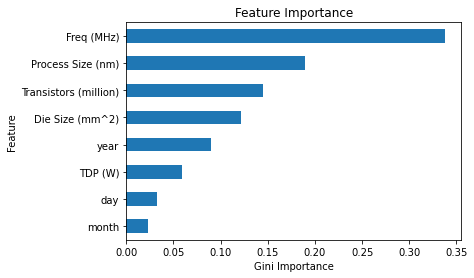

In [29]:
# Get feature names from training data
features = X_train.columns
# Extract importances from model
importances = model_rf.best_estimator_.named_steps["randomforestclassifier"].feature_importances_
# Create a series with feature names and importances
feat_imp = pd.Series(importances, index=features)
# Plot 10 most important features
feat_imp.sort_values().tail(10).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

### Evaluating the model:

In [30]:
acc_train = model_rf.score(X_train, y_train)
acc_test = model_rf.score(X_test, y_test)

print("Random Forest with OverSampler:")
print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))
print("Baseline Accuracy:", round(acc_baseline, 4))

Random Forest with OverSampler:
Training Accuracy: 1.0
Test Accuracy: 0.9872
Baseline Accuracy: 0.5554


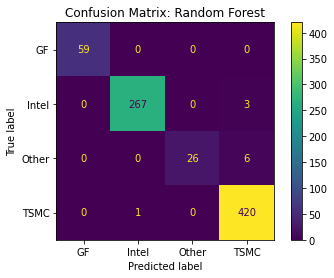

In [31]:
ConfusionMatrixDisplay.from_estimator(model_rf,X_test,y_test)
plt.title("Confusion Matrix: Random Forest");

In [32]:
print("Random Forest classification report:")
print(classification_report(y_test, model_rf.predict(X_test)))

Random Forest classification report:
              precision    recall  f1-score   support

          GF       1.00      1.00      1.00        59
       Intel       1.00      0.99      0.99       270
       Other       1.00      0.81      0.90        32
        TSMC       0.98      1.00      0.99       421

    accuracy                           0.99       782
   macro avg       0.99      0.95      0.97       782
weighted avg       0.99      0.99      0.99       782



# Using the model to predict Unknown Values

In [33]:
df["Foundry"].value_counts()

TSMC       2156
Intel      1341
Unknown     838
GF          264
Other       145
Name: Foundry, dtype: int64

In [34]:
lista = ['Process Size (nm)', 'TDP (W)', 'Die Size (mm^2)', 'Transistors (million)', 'Freq (MHz)', "day", "month", "year"]

In [35]:
for i in range(len(df)):
    if df.loc[i, "Foundry"] == "Unknown":
        df.loc[i, "Foundry"] = model_rf.predict(df.loc[i, lista].to_frame().T)

In [36]:
model_rf.predict(df.loc[0, lista].to_frame().T)

array(['Intel'], dtype=object)

In [37]:
df.loc[0, lista].to_frame().T

,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),day,month,year
0,65.0,45.0,77.0,122.0,2200.0,20.0,2.0,2007.0


In [38]:
df["Foundry"].value_counts()

TSMC     2253
Intel    2075
GF        270
Other     146
Name: Foundry, dtype: int64

In [39]:
df.to_csv("Foundry.csv")